In [2]:
%matplotlib inline
import IPython.display
from ipywidgets import interact, interactive, fixed

import os
import numpy as np
from scipy.io import wavfile
from utils import butter_bandpass_filter, get_timit_dict, get_target, create_mel_filter, pretty_spectrogram, make_mel
import matplotlib.pyplot as plt
from python_speech_features import mfcc

In [ ]:
dirlist = "./data/"

spectograms = []
# preprocess feature data
for d in dirlist:
    for dirName, subdirList, fileList in os.walk("./data/TRAIN/"):
        for fname in fileList:
            if not fname.endswith('.PHN') or (fname.startswith("SA")): 
                continue

            phn_fname = dirName + '\\' + fname
            wav_fname = dirName + '\\' + fname[0:-4] + '.WAV'
            
            rate, data = wavfile.read(wav_fname)
            data = butter_bandpass_filter(data, 500, 7999, rate, order=1)
            spect = pretty_spectrogram(data.astype('float64'))
            spectograms.append(spect)
            
len(spectograms)
        
#IPython.display.Audio(data=data, rate=rate)

Text(0.5,1.05,'Original Spectrogram')

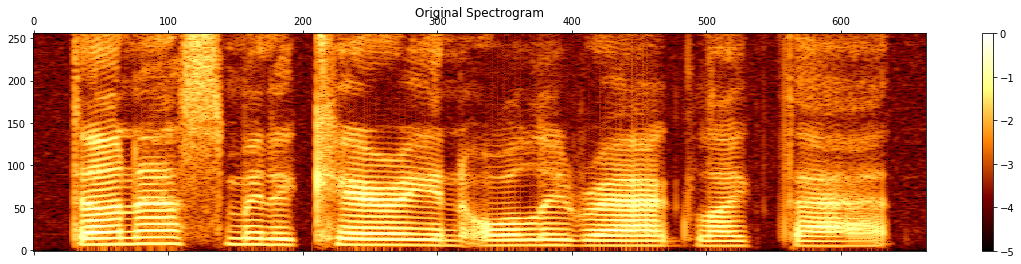

In [8]:
rate, data = wavfile.read("./data/TRAIN/DR1FDAW0SA2.WAV")
data = butter_bandpass_filter(data, 500, 7999, rate, order=1)

wav_spectrogram = pretty_spectrogram(data.astype('float64'))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Original Spectrogram')

In [4]:
mfcc_data = mfcc(data, rate)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,4))
cax = ax.matshow(mfcc, interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('MFCC')

NameError: name 'data' is not defined